In [1]:
# numeric imports
import torch
import numpy 
# gp imports
import gpytorch
from src.models.exact.univariate_structure import Matern12GP
from src.models.sparse.univariate_structure import Matern12SVGP, Matern12VFFGP, Matern12B1SplineASVGP, Matern12B0SplineGriddedGP
# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
# utils imports
from src.utils.datagenerators import gen_1d
# misc imports
from tqdm import tqdm

In [2]:
plt.style.use('seaborn-v0_8-paper')

In [3]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


# Generate Noisy Data

In [4]:
# latent function
latent_function = lambda x : torch.sin(x) + torch.cos(x)

In [5]:
# meta
LEFTLIM = 0.
RIGHTLIM = 2.
N_OBS = 15

In [6]:
# generate data
X, y = gen_1d(fun = latent_function, leftlim = LEFTLIM, rightlim = RIGHTLIM, nobs = N_OBS, randomspacing = False)

In [7]:
# add noise
y += torch.distributions.Normal(0, 0.05).sample(y.shape)

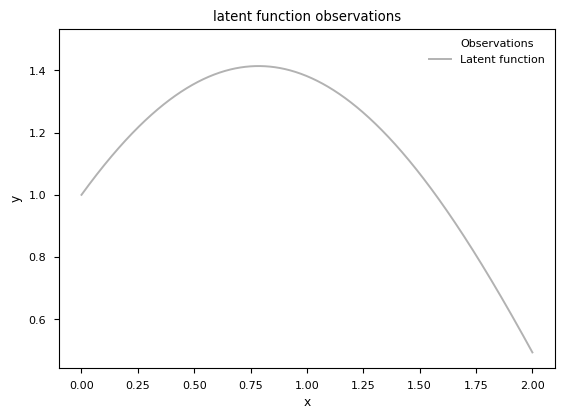

In [8]:
# plot data
plt.plot(X, y, 'x', color = 'red', label = 'Observations')
plt.plot(torch.linspace(LEFTLIM, RIGHTLIM, 1000), latent_function(torch.linspace(LEFTLIM, RIGHTLIM, 1000)), color = 'black', alpha = 0.3, label = 'Latent function') # true function
plt.title('latent function observations')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(frameon=False)

In [9]:
# make training data
X_train = X.clone().detach().to(torch.float64)
y_train = y.clone().detach().to(torch.float64)

In [10]:
# make test data
X_test = torch.linspace(LEFTLIM, RIGHTLIM, 100).to(torch.float64)

# Matern 12 GPs

## Exact GP

In [11]:
exact_gp = Matern12GP(X_train, y_train)

In [12]:
# fit the Exact GP
EXACT_GP_LR = 0.01
EXACT_GP_ITERATIONS = 1000
# set model and likelihood into training mode
exact_gp.train()
exact_gp.likelihood.train()
# define the optimizer
optimizer = torch.optim.Adam(exact_gp.parameters(), lr = EXACT_GP_LR)
# define the mll
mll = gpytorch.mlls.ExactMarginalLogLikelihood(exact_gp.likelihood, exact_gp)
for i in tqdm(range(EXACT_GP_ITERATIONS)):
    optimizer.zero_grad()
    output = exact_gp(exact_gp.train_x)
    loss = -mll(output, exact_gp.train_y)
    loss.backward()
    optimizer.step()

print('='*((5*15) + 4))
print(f"{'Iteration':^15}|{'Loss':^15}|{'Noise':^15}|{'Lengthscale':^15}|{'Outputscale':^15}")
print('='*((5*15) + 4))
print(f"{i+1:^15}|{loss.item():^15.3f}|{exact_gp.likelihood.noise.item():^15.3f}|{exact_gp.kernel.base_kernel.lengthscale.item():^15.3f}|{exact_gp.kernel.outputscale.item():^15.3f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 324.23it/s]

   Iteration   |     Loss      |     Noise     |  Lengthscale  |  Outputscale  
     1000      |    -0.445     |     0.001     |     5.682     |     0.383     


## SVGP

In [13]:
N_INDUCING = 10
Z = torch.linspace(LEFTLIM, RIGHTLIM, N_INDUCING).to(torch.float64)

In [14]:
sv_gp = Matern12SVGP(X_train, y_train, Z).to(torch.float64)

In [15]:
# fit the SVGP
SVGP_LR = 0.01
SVGP_ITERATIONS = 1000
optimizer = torch.optim.Adam(sv_gp.parameters(), lr=0.1)
# perform gradient descent
history = torch.empty(SVGP_ITERATIONS)
for i in tqdm(range(SVGP_ITERATIONS)):
    optimizer.zero_grad()
    elbow = -sv_gp._elbo()
    history[i] = elbow.item()
    elbow.backward()
    optimizer.step()
;

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
100%|██████████| 1000/1000 [00:05<00:00, 182.90it/s]


''

## VFFGP

In [30]:
N_FREQ = 10
VFFLIMS = (-1, 3)

In [31]:
vff_gp = Matern12VFFGP(X_train, y_train, N_FREQ, VFFLIMS).to(torch.float64)

In [32]:
# fit the VFFGP
VFFGP_LR = 0.01
VFFGP_ITERATIONS = 1000
optimizer = torch.optim.Adam(vff_gp.parameters(), lr=VFFGP_LR)
# perform gradient descent
history = torch.empty(VFFGP_ITERATIONS)
for i in tqdm(range(VFFGP_ITERATIONS)):
    optimizer.zero_grad()
    elbow = -vff_gp._elbo()
    history[i] = elbow.item()
    elbow.backward()
    optimizer.step()
;

100%|██████████| 1000/1000 [00:06<00:00, 154.96it/s]


''

## ASVGP

In [19]:
N_KNOTS = 15
ASVGPLIMS = (-1, 3)

In [20]:
asv_gp = Matern12B1SplineASVGP(X_train, y_train, N_KNOTS, ASVGPLIMS).to(torch.float64)

In [21]:
# fit the VFFGP
ASVGP_LR = 0.1
VASVGP_ITERATIONS = 1000
optimizer = torch.optim.Adam(asv_gp.parameters(), lr=ASVGP_LR)
# perform gradient descent
history = torch.empty(VASVGP_ITERATIONS)
for i in tqdm(range(VASVGP_ITERATIONS)):
    optimizer.zero_grad()
    elbow = -asv_gp._elbo()
    history[i] = elbow.item()
    elbow.backward()
    optimizer.step()
;

100%|██████████| 1000/1000 [00:13<00:00, 73.43it/s]


''

## GriddedGP

In [22]:
N_KNOTS = 10
GRIDDEDLIMS = (0., 2.)

In [23]:
gridded_gp = Matern12B0SplineGriddedGP(X_train, y_train, N_KNOTS, GRIDDEDLIMS).to(torch.float64)

In [24]:
# fit the VFFGP
GRIDDEDGP_LR = 0.01
GRIDDEDGP_ITERATIONS = 1000
optimizer = torch.optim.Adam(gridded_gp.parameters(), lr=GRIDDEDGP_LR)
# perform gradient descent
history = torch.empty(GRIDDEDGP_ITERATIONS)
for i in tqdm(range(GRIDDEDGP_ITERATIONS)):
    optimizer.zero_grad()
    elbow = -gridded_gp._elbo()
    history[i] = elbow.item()
    elbow.backward()
    optimizer.step()
;

100%|██████████| 1000/1000 [00:06<00:00, 164.18it/s]


''

# Model Comparison

In [25]:
plt.rcParams.update(plt.rcParamsDefault)

In [26]:
%matplotlib inline

In [27]:
plt.style.use('tableau-colorblind10')

''

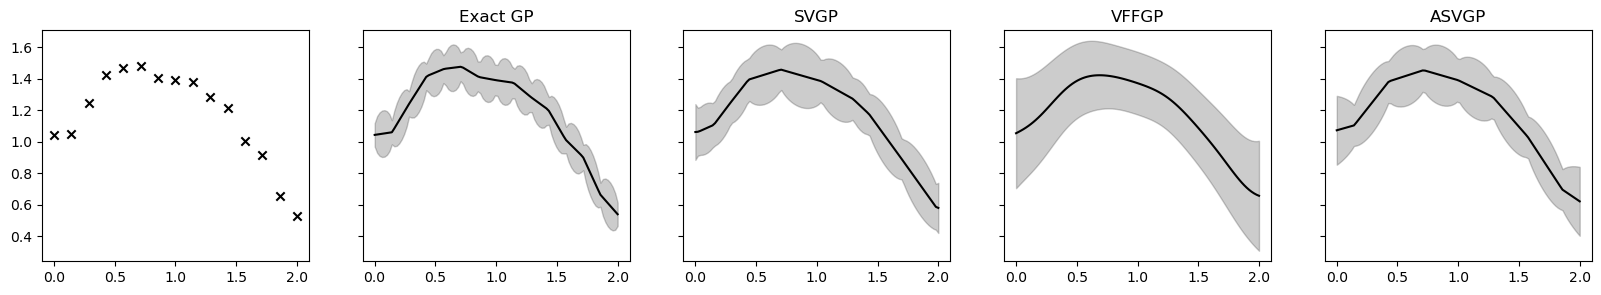

In [33]:


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 3), sharey=True, sharex=True)
# data
ax1.scatter(X_train, y_train, color='black', marker='x', label='Training Data')

# exact gp
f_pred_exact_gp = exact_gp.posterior(X_test)
l_exact_gp, u_exact_gp = f_pred_exact_gp.confidence_region()
ax2.plot(X_test, f_pred_exact_gp.mean, color='black', label='Exact GP')
ax2.fill_between(X_test.squeeze(), l_exact_gp, u_exact_gp, alpha=0.2, color='black')
ax2.set_title('Exact GP')

# svgp
f_pred_sv_gp = sv_gp.posterior(X_test)
l_sv_gp, u_sv_gp = f_pred_sv_gp.confidence_region()
ax3.plot(X_test, f_pred_sv_gp.mean.detach().numpy(), color='black', label='SVGP')
ax3.fill_between(X_test, l_sv_gp.detach().numpy(), u_sv_gp.detach().numpy(), alpha=0.2, color='black')
ax3.set_title('SVGP')

# vffgp
f_pred_vff_gp = vff_gp.posterior(X_test)
l_vff_gp, u_vff_gp = f_pred_vff_gp.confidence_region()
ax4.plot(X_test, f_pred_vff_gp.mean.detach().numpy(), color='black', label='VFFGP')
ax4.fill_between(X_test, l_vff_gp.detach().numpy(), u_vff_gp.detach().numpy(), alpha=0.2, color='black')
ax4.set_title('VFFGP')

# asvgp
f_pred_asv_gp = asv_gp.posterior(X_test)
l_asv_gp, u_asv_gp = f_pred_asv_gp.confidence_region()
ax5.plot(X_test, f_pred_asv_gp.mean.detach().numpy(), color='black', label='ASVGP')
ax5.fill_between(X_test, l_asv_gp.detach().numpy(), u_asv_gp.detach().numpy(), alpha=0.2, color='black')
ax5.set_title('ASVGP')

# #Gridded GP
# f_pred_grid_gp = gridded_gp.q_v()
# l_grid_gp, u_grid_gp = f_pred_grid_gp.confidence_region()
# grid_centre_points = gridded_gp.mesh[1:] - gridded_gp.delta / 2
# ax6.bar(grid_centre_points, f_pred_grid_gp.mean.detach().numpy(), yerr = torch.diagonal(f_pred_grid_gp.covariance_matrix).detach().numpy())
;
